# Imports

In [ ]:
import librosa
import os
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import scale
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import io

2025-05-05 20:40:33.716654: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Base Directories

In [2]:
#base path for each kind of data
train_dataset_path = '/home/enriq115/dev/research/cs478/FinalProject/Data/ASVspoof2017_V2_train'
eval_dataset_path = '/home/enriq115/dev/research/cs478/FinalProject/Data/ASVspoof2017_V2_eval'
dev_dataset_path = '/home/enriq115/dev/research/cs478/FinalProject/Data/ASVspoof2017_V2_dev'

spect_eval_path = '/home/enriq115/dev/research/cs478/FinalProject/spectrogram_images_output/testing'
spect_train_path = '/home/enriq115/dev/research/cs478/FinalProject/spectrogram_images_output/training'
spect_dev_path = '/home/enriq115/dev/research/cs478/FinalProject/spectrogram_images_output/validation'
print(train_dataset_path)

/home/enriq115/dev/research/cs478/FinalProject/Data/ASVspoof2017_V2_train


# Wav2Vec Extract Embeddings
Does not need to be run if you already created test_data.npz, train_data.npz, and val_data.npz.
Just load these instead of extracting embeddings again

In [2]:
def loadWavDataset(csv_path, wav_path):
    df = pd.read_csv(csv_path)
    df["Label"] = df["Label"].map({"genuine": 0, "spoof": 1})
    label_map = dict(zip(df["File"], df["Label"]))  # Maps: filename → label
    file_list = list(label_map.keys())
    dataset = [(os.path.join(wav_path, fname), label_map[fname]) for fname in file_list]
    return dataset

training_dataset = loadWavDataset(
    '/home/enriq115/dev/research/cs478/FinalProject/Data/ASVspoof2017_V2_train.csv',
    'home/enriq115/dev/research/cs478/FinalProject/Data/ASVspoof2017_V2_train')

val_dataset = loadWavDataset(
    '/home/enriq115/dev/research/cs478/FinalProject/Data/ASVspoof2017_V2_dev.csv',
    'home/enriq115/dev/research/cs478/FinalProject/Data/ASVspoof2017_V2_dev')

test_dataset = loadWavDataset(
    '/home/enriq115/dev/research/cs478/FinalProject/Data/ASVspoof2017_V2_eval.csv',
    'home/enriq115/dev/research/cs478/FinalProject/Data/ASVspoof2017_V2_eval')


In [ ]:
#Import models from Hugging face

#THIS USES LOCAL DOWNLOADED MODELS FROM HUGGING FACE. 
#If you don't have these and try to download models from Hugging face online modify "models/wav2vec-base" to "facebook/wav2vec2-base"
#If downloading models locally, make sure to download config.json, preprocessor_config.json, pytorch_model.bin, vocab.json, tokenizer_config.json, special_tokens_map.json files from Hugging face and place them in the models/wav2vec2-base directory

from transformers import Wav2Vec2Processor, Wav2Vec2Model
processor = Wav2Vec2Processor.from_pretrained("models/wav2vec2-base")
model = Wav2Vec2Model.from_pretrained("models/wav2vec2-base")
model.eval()  # Inference mode

/home/enriq115/miniconda3/envs/my_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/enriq115/miniconda3/envs/my_env/lib/python3.11/site-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Wav2Vec2Encoder(
    (pos_conv_embed): Wav2Vec2PositionalConvEmbedding(
  

In [ ]:
import torch
def load_audio(path):
    sig, sr = librosa.load(path, sr=16000, mono=True)
    return sig

#Function to extract embeddings from a wav file. 
def extract_embedding(audio_array):
    inputs = processor(audio_array, sampling_rate=16000, return_tensors="pt", padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embedding

In [ ]:
#Give directory to a dataset to extract embeddings from all wav files
def wev2vec_embedding_extract(dataset):
    embeddings = []
    labels = []

    print("Extracting embeddings...")
    for path, label in dataset:
        try:
            audio_array = load_audio(path)
            emb = extract_embedding(audio_array)
            embeddings.append(emb)
            labels.append(label)
        except Exception as e:
            print(f"⚠️ Error processing {path}: {e}")

    X = np.array(embeddings)
    y = np.array(labels)

    print(f"\n✅ Finished! Final dataset shape: X = {X.shape}, y = {y.shape}")
    return X, y


In [ ]:
X_train, y_train = wev2vec_embedding_extract(training_dataset)
X_test, y_test = wev2vec_embedding_extract(test_dataset)
X_val, y_val = wev2vec_embedding_extract(val_dataset)

# Load Previously Extracted Embeddings

In [32]:
# Load later
train_data = np.load('train_data.npz')
X_train = train_data['X']
y_train = train_data['y']

test_data = np.load('test_data.npz')
X_test = test_data['X']
y_test = test_data['y']

val_data = np.load('val_data.npz')
X_val = val_data['X']
y_val = val_data['y']

In [ ]:
from sklearn.preprocessing import StandardScaler

#Standardize and scale X arrays. Optional
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [ ]:
# Reshape datasets so they are treated as 1D images and can use them as input for CNN
X_train = X_train.reshape((-1, X_train.shape[1], 1))
X_val = X_val.reshape((-1, X_val.shape[1], 1))
X_test = X_test.reshape((-1, X_test.shape[1], 1))

In [ ]:
#Mainly for checking X has correct shape
X_train.shape

(3014, 768, 1)

# CNN Model (Uses same CNN model from paper just to compare performance)

In [ ]:
from tensorflow.keras import backend as K

def wav2vec_cnn_model():
    K.clear_session()
    tf.random.set_seed(42) 
    model = models.Sequential()
    #Input Spectrogram/MFCC
    model.add(layers.InputLayer(input_shape=(X_train.shape[1], 1)))
    
    #First 2D Conv Layer and 2d Max Pooling
    model.add(layers.Conv1D(filters=16, kernel_size=3, activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=2))

    #Second 2d Conv layer followed by Global Max Pooling
    model.add(layers.Conv1D(filters=8, kernel_size=3, activation='relu'))
    model.add(layers.GlobalMaxPooling1D()) 

    # Fully connected layer for classification
    model.add(layers.Dense(1, activation='sigmoid')) 

    custom_learning_rate = 0.001
    optimizer = Adam(learning_rate=custom_learning_rate)

    # Compile the model with the custom optimizer 
    model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=["accuracy"])  
    model.summary()
    return model


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

model = wav2vec_cnn_model()

early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,  # Less aggressive stop
    min_delta=1e-4,  # Stop only if loss change is "small enough"
    restore_best_weights=True
)
model.fit(
    X_train, 
    y_train,    
    epochs=30,
    steps_per_epoch=8,
    validation_data = (X_val, y_val),
    
)

/home/enriq115/miniconda3/envs/my_env/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 766, 16)        │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 383, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 381, 8)         │           392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 8)              │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 465 (1.82 KB)

 Trainable params: 465 (1.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4900 - loss: 0.6992 - val_accuracy: 0.5532 - val_loss: 0.6852
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5030 - loss: 0.6897 - val_accuracy: 0.5918 - val_loss: 0.6877
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6628 - loss: 0.6844 - val_accuracy: 0.5807 - val_loss: 0.6884
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7425 - loss: 0.6802 - val_accuracy: 0.5772 - val_loss: 0.6871
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7468 - loss: 0.6762 - val_accuracy: 0.5965 - val_loss: 0.6851
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7585 - loss: 0.6725 - val_accuracy: 0.6053 - val_loss: 0.6836
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7615 - loss: 0.6689 - val_accuracy: 0.6123 - val_loss: 0.6827
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7677 - loss: 0.6652 - val_accuracy: 0.5918 - val_loss: 0.6820


# Predict on data

30/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
416/416 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

=== Classification Report — Train ===
              precision    recall  f1-score   support

     Genuine       0.83      0.81      0.82      1507
       Spoof       0.81      0.84      0.82      1507

    accuracy                           0.82      3014
   macro avg       0.82      0.82      0.82      3014
weighted avg       0.82      0.82      0.82      3014



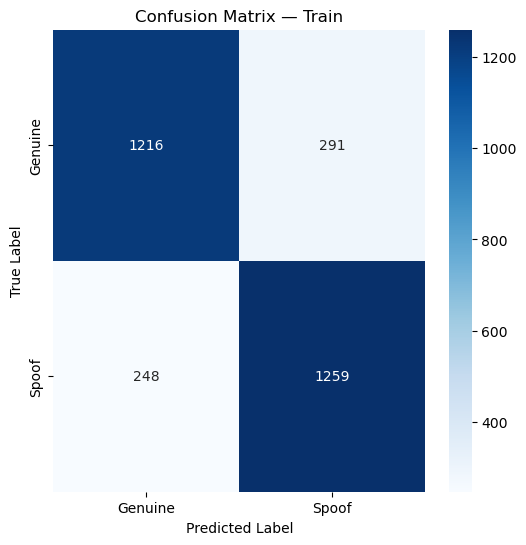


=== Classification Report — Validation ===
              precision    recall  f1-score   support

     Genuine       0.52      0.69      0.60       760
       Spoof       0.67      0.50      0.57       950

    accuracy                           0.58      1710
   macro avg       0.60      0.59      0.58      1710
weighted avg       0.60      0.58      0.58      1710



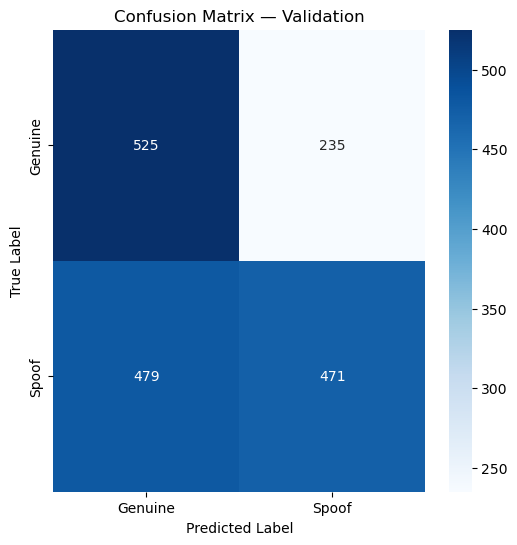


=== Classification Report — Test ===
              precision    recall  f1-score   support

     Genuine       0.13      0.73      0.23      1298
       Spoof       0.94      0.49      0.64     12008

    accuracy                           0.51     13306
   macro avg       0.54      0.61      0.43     13306
weighted avg       0.86      0.51      0.60     13306



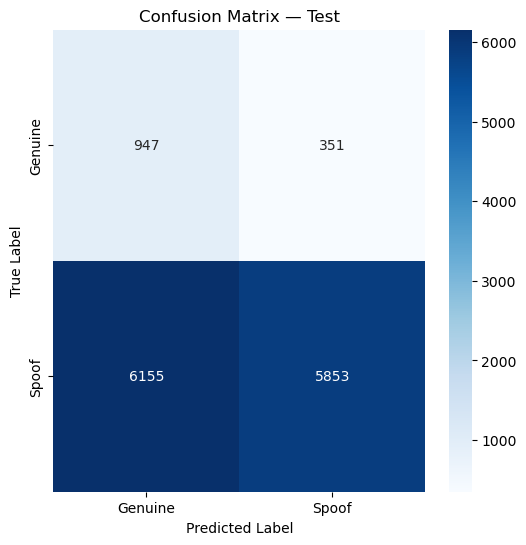

In [55]:
y_pred_train_raw = model.predict(X_train)
y_pred_val_raw   = model.predict(X_val)
y_pred_test_raw  = model.predict(X_test)

def to_labels(probs):
    if probs.ndim > 1 and probs.shape[1] > 1:
        return probs.argmax(axis=1)
    # threshold at 0.5
    return (probs > 0.5).astype(int).ravel()

y_pred_train = to_labels(y_pred_train_raw)
y_pred_val   = to_labels(y_pred_val_raw)
y_pred_test  = to_labels(y_pred_test_raw)

# Define class names
target_names = ['Genuine', 'Spoof']

#loop through each split
for split_name, y_true, y_pred in [
    ('Train',      y_train, y_pred_train),
    ('Validation', y_val,   y_pred_val),
    ('Test',       y_test,  y_pred_test)
]:
    print(f"\n=== Classification Report — {split_name} ===")
    print(classification_report(y_true, y_pred, target_names=target_names))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix — {split_name}')
    plt.show()

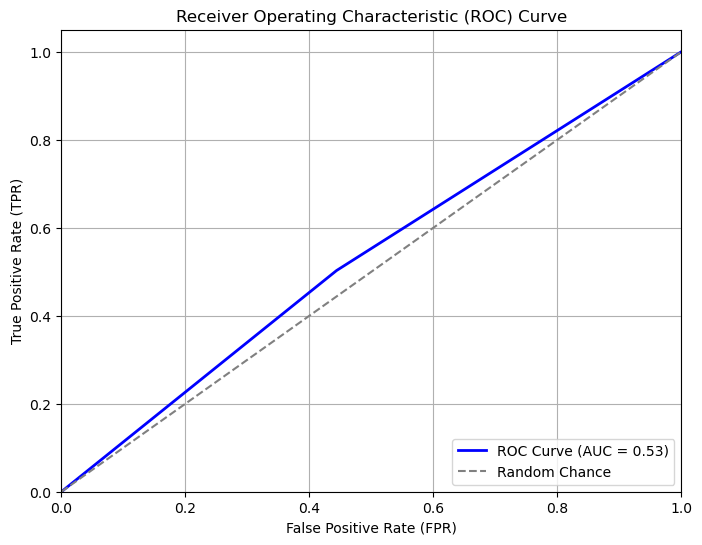

In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Flatten if needed
y_test_flat = y_test.ravel()
y_pred_probs_flat = y_pred.ravel()

# Get FPR, TPR, thresholds
fpr, tpr, thresholds = roc_curve(y_test_flat, y_pred_probs_flat)

# Area Under Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
